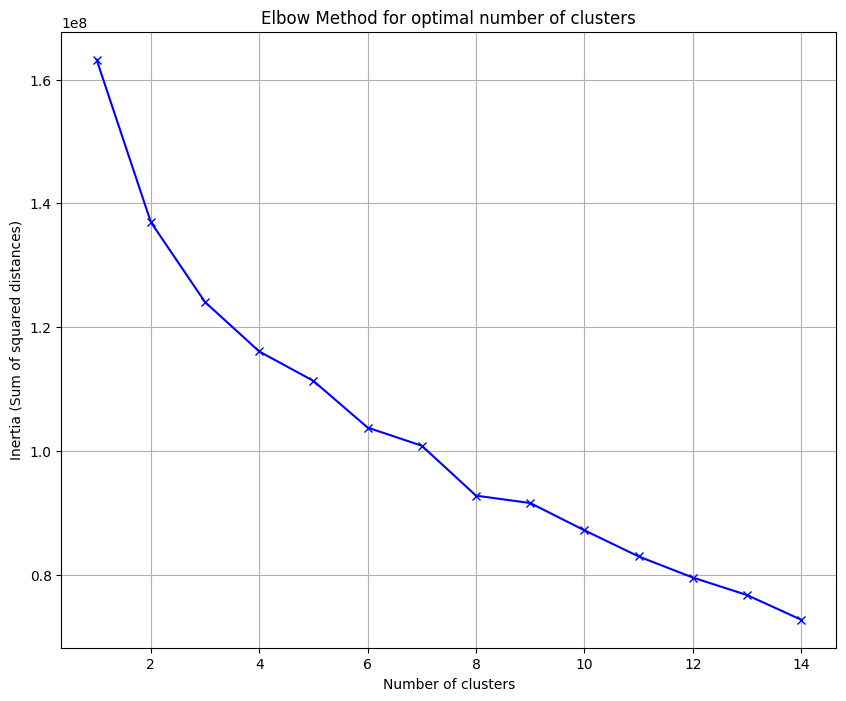

Optimal number of clusters (Elbow Method): 9


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import logging
import os
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to preprocess age
def preprocess_age(age):
    if pd.isnull(age):  # Check for missing values
        return np.nan
    elif isinstance(age, str):  # Handle age ranges
        try:
            age_split = age.split(' - ')
            start_age = int(age_split[0])
            end_age = int(age_split[1])
            average_age = (start_age + end_age) / 2
            return average_age
        except (ValueError, IndexError) as e:
            logging.error(f"Error processing age '{age}': {str(e)}")
            return np.nan
    else:  # Handle float values
        return age

# Function to preprocess gender
def preprocess_gender(gender):
    gender_encoder = LabelEncoder()
    gender_encoded = gender_encoder.fit_transform([gender])
    return gender_encoded[0]

# Function to preprocess income level
def preprocess_income_level(income_level):
    income_map = {'low': 0, 'middle': 1, 'high': 2}
    return income_map.get(income_level.lower(), 0)

# Function to preprocess image
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        with open(image_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')  # Convert to RGB format if image has an alpha channel
            img = img.resize(target_size)
            image_array = np.array(img) / 255.0
            return image_array.flatten()  # Flatten the image array to a 1D array
    except Exception as e:
        logging.error(f"Error preprocessing image from {image_path}: {str(e)}")
        return None

# Function to preprocess data from CSV file
def preprocess_data(csv_file):
    # Read data from CSV file
    data = pd.read_csv(csv_file)

    # Preprocess each row in the CSV file
    feature_matrix = []
    for index, row in data.iterrows():
        age = preprocess_age(row['Age'])
        gender = preprocess_gender(row['Gender'])
        income_level = preprocess_income_level(row['IncomeLevel'])

        # Preprocess images
        image_features = []
        image_paths = [row['Color'], row['Decor'], row['Lightning'], row['Furniture'], row['StylingStation'], row['WashingStation'], row['WaitingArea']]
        for image_path in image_paths:
            img = preprocess_image(image_path)
            if img is not None:
                image_features.extend(img)
            else:
                image_features.extend([0] * (128 * 128 * 3))  # Handle missing images by adding zeroed arrays

        # Append features to feature matrix for clustering
        feature_vector = [age, gender, income_level] + image_features
        feature_matrix.append(feature_vector)

    feature_matrix = np.array(feature_matrix)

    # Handle missing values by removing rows with NaN values
    feature_matrix = feature_matrix[~np.isnan(feature_matrix).any(axis=1)]

    # Scale features
    scaler = StandardScaler()
    feature_matrix = scaler.fit_transform(feature_matrix)

    return feature_matrix

# Load and preprocess data
csv_file = "/content/drive/MyDrive/Final Research/salondataset.csv"
feature_matrix = preprocess_data(csv_file)

# Elbow Method for KMeans Clustering
def elbow_method(feature_matrix):
    inertia_scores = []
    K = range(1, 15)  # Try different cluster sizes
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(feature_matrix)
        inertia_scores.append(kmeans.inertia_)  # Append the inertia (sum of squared distances to centroids)

    # Plot the Elbow Method
    plt.figure(figsize=(10, 8))
    plt.plot(K, inertia_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.title('Elbow Method for optimal number of clusters')
    plt.grid(True)
    plt.show()

    # Determine the optimal k based on elbow method
    optimal_k = np.argmax(np.diff(inertia_scores)) + 2  # Approximation using the first major drop in inertia
    print(f"Optimal number of clusters (Elbow Method): {optimal_k}")

# Plot Elbow Method
elbow_method(feature_matrix)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=9, cluster_std=0.60, random_state=0)

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 15))  # Testing from 2 to 10 clusters

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)

    # Predict cluster labels
    cluster_labels = kmeans.predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

# Find the optimal number of clusters based on the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")

# Plot silhouette scores for different number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various Numbers of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=9, cluster_std=0.60, random_state=0)

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 15))  # Testing from 2 to 14 clusters

# Initialize lists to store silhouette scores and inertia (elbow method)
silhouette_scores = []
inertias = []

# Loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)

    # Predict cluster labels
    cluster_labels = kmeans.predict(X)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Store inertia for the elbow method
    inertias.append(kmeans.inertia_)

    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}, Inertia: {kmeans.inertia_}")

# Find the optimal number of clusters based on the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {optimal_n_clusters}")

# Plot silhouette scores for different number of clusters
plt.figure(figsize=(15, 5))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various Numbers of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)

# Elbow method plot (inertia)
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, inertias, marker='x', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Number of clusters: 2, Silhouette Score: 0.5479635788552965, Inertia: 9902.044097516955
Number of clusters: 3, Silhouette Score: 0.5382321747705286, Inertia: 4682.463066764834
Number of clusters: 4, Silhouette Score: 0.6238024297396862, Inertia: 2172.598231684123
Number of clusters: 5, Silhouette Score: 0.6452908609814144, Inertia: 1028.1807340747928
Number of clusters: 6, Silhouette Score: 0.6338506269570612, Inertia: 690.5556718335718
Number of clusters: 7, Silhouette Score: 0.6689615031929645, Inertia: 465.8060255810743
Number of clusters: 8, Silhouette Score: 0.6712210002909598, Inertia: 332.2152668610508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Number of clusters: 9, Silhouette Score: 0.7077888054308611, Inertia: 206.13680061283418
Number of clusters: 10, Silhouette Score: 0.6493406554229407, Inertia: 194.18309787921967
Number of clusters: 11, Silhouette Score: 0.608486887462612, Inertia: 183.53958419857156
Number of clusters: 12, Silhouette Score: 0.5809184698671443, Inertia: 175.09677807056835
Number of clusters: 13, Silhouette Score: 0.5354727764869013, Inertia: 165.35381951417992


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
